In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'sample_submission.csv']


**Importing Some important libraries

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score

**Let's create a Dataframe for both Train and Test CSV files.

In [3]:
TrainDF = pd.read_csv("../input/train.csv")
TestDF = pd.read_csv("../input/test.csv")
RawData_DF = pd.concat([TrainDF,TestDF])
RawData_DF.describe()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,target,var_0,var_1,var_10,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_11,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_12,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_13,var_130,var_131,var_132,...,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_7,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_8,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_9,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99
count,200000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,...,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000
mean,0.100490,10.669326,-1.625933,0.382838,-6.637266,13.401424,22.314640,1.568550,11.516480,4.244527,8.619354,17.810271,14.224771,18.456729,-3.257074,5.505527,6.313147,3.314818,8.140896,3.083677,2.206722,2.397314,16.071079,-5.307828,3.046695,14.023320,24.528588,11.311663,1.192366,7.050095,4.276160,12.488641,13.203965,0.849341,-1.130284,15.447663,8.535552,12.257005,0.546038,7.800636,...,0.667201,6.368852,0.979625,5.790350,11.912412,5.018873,-3.332953,16.537496,24.444676,0.670017,0.644650,19.612242,19.482050,16.865129,6.061118,19.069423,5.349164,14.404680,0.280648,5.805062,14.724477,-3.448736,1.023665,-2.577745,18.374720,5.629497,11.365552,8.720486,3.726999,7.568322,-16.441561,6.987878,12.737552,10.556830,10.994161,-0.086558,14.412906,18.571498,1.751853,-0.745985
std,0.300653,3.038398,4.045275,5.504734,9.181724,4.951957,8.629497,0.185157,1.972356,0.856708,1.892779,7.601799,0.171265,4.361839,5.965853,3.828978,1.081337,1.591965,4.465790,0.984588,2.622417,1.651840,13.277273,8.783346,4.179023,0.190066,12.113365,1.711527,5.156954,6.144063,2.732768,0.317908,0.777546,3.143987,3.240706,4.141417,4.634124,0.832565,0.456510,1.455547,...,3.112133,1.483126,3.787927,1.122863,7.367883,0.007190,3.957678,3.421286,11.942759,0.266516,3.950890,7.470204,14.095730,6.070204,7.952193,3.818225,1.995299,1.308478,3.333002,7.432127,2.297314,8.452825,8.273931,6.227054,3.910034,7.756926,5.651686,2.494532,3.559293,1.233468,13.164241,0.152941,4.192629,0.542811,2.766883,0.619137,8.539102,12.658446,0.714815,1.865661
min,0.000000,0.188700,-15.043400,-22.672400,-40.949000,-0.644800,-7.925600,0.967500,3.852600,0.715300,0.942400,-6.542200,13.729000,5.078200,-26.095000,-9.396400,2.194200,-2.379600,-5.513900,-0.050500,-6.875000,-3.163000,-37.607300,-38.295700,-9.774200,13.424500,-19.541500,6.305200,-15.194000,-12.405900,-7.053800,11.486100,11.265400,-8.876900,-11.755900,2.186300,-6.011100,9.528300,-0.954800,2.890000,...,-12.600400,1.486700,-15.242900,1.336800,-19.544300,4.993800,-16.309400,5.349700,-17.027500,-0.224000,-12.728300,-1.665800,-37.347000,-1.293600,-21.633300,7.425700,-1.818300,10.445400,-10.505500,-18.042200,7.586500,-30.314600,-24.709100,-24.563900,7.023000,-19.272200,-8.481600,1.350200,-9.601400,3.970500,-61.718000,6.521800,-1.018500,8.491600,2.817100,-2.432400,-1

**We have checked In dataset, null & NaN values are not present !

In [4]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [ ]:
display_all(TrainDF)

**Counts of target variables 0 and 1  in order to see what is the distribution .

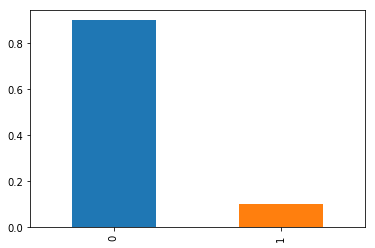

In [5]:
((TrainDF['target'].value_counts())/len(TrainDF)).plot.bar()

As we can data is skewed 90% data having target var as 0 and other 10% have lebel 1.

In [6]:
len(TrainDF[TrainDF['target']==0.0]),len(TrainDF[TrainDF['target']==1.0])

(179902, 20098)

In [7]:
TrainDF['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

In [8]:
TrainPositive = TrainDF[TrainDF['target'] == 1.0]
TrainPositive.shape

(20098, 202)

**Hyperparameter tuning **
Since data is skewed we are doing sampling kepping 25% data of label 0. In order make robust model.

In [9]:
TrainSF = TrainDF[TrainDF['target'] == 0.0].sample(frac=0.25, random_state=1)
TrainSF.shape

(44976, 202)

In [10]:
TrainDF = pd.concat([TrainSF,TrainPositive])

In [11]:
TrainDF['target'].value_counts()

0    44976
1    20098
Name: target, dtype: int64

Creating train and validation data. we are making 20% data a validation****

In [12]:
X_train, X_val, y_train, y_val = train_test_split(
    TrainDF.drop(['ID_code','target'], axis=1),
    TrainDF['target'],
    test_size=0.2, random_state=42)

In [13]:
X_train.shape,y_train.shape,X_val.shape,y_val.shape

((52059, 200), (52059,), (13015, 200), (13015,))

XGBoost import****

In [14]:
import xgboost as xgb
import matplotlib.pyplot as pyplot

In [15]:
d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_val, label=y_val)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [16]:
param = {'max_depth': 4, 'eta': .4, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
param['min_child_weight'] = 5
param['subsample'] = .5

In [17]:
evallist = [(d_train, 'train'),(d_valid, 'eval')]

Training XGboost molel below****

In [18]:
num_round = 50
bst = xgb.train(param, d_train, num_round, evallist, 
                early_stopping_rounds=10)

[0]	train-auc:0.627412	eval-auc:0.622895
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.673267	eval-auc:0.657457
[2]	train-auc:0.700838	eval-auc:0.679027
[3]	train-auc:0.721753	eval-auc:0.70151
[4]	train-auc:0.735064	eval-auc:0.708948
[5]	train-auc:0.751061	eval-auc:0.724807
[6]	train-auc:0.764427	eval-auc:0.738306
[7]	train-auc:0.773058	eval-auc:0.746636
[8]	train-auc:0.781551	eval-auc:0.751365
[9]	train-auc:0.790396	eval-auc:0.760959
[10]	train-auc:0.798042	eval-auc:0.767419
[11]	train-auc:0.805084	eval-auc:0.771612
[12]	train-auc:0.811346	eval-auc:0.774054
[13]	train-auc:0.816761	eval-auc:0.781024
[14]	train-auc:0.821207	eval-auc:0.784746
[15]	train-auc:0.826279	eval-auc:0.788931
[16]	train-auc:0.831091	eval-auc:0.793583
[17]	train-auc:0.83554	eval-auc:0.797643
[18]	train-auc:0.839023	eval-auc:0.799057
[19]	train-auc:0.842229	eval-auc:0.802251
[20]	train-auc:0.844825	eval-au

We can see above that our xgboost model is predicting around 89% ,however on validation data it is 83% accurate.****

In [19]:
 check = bst.predict(xgb.DMatrix(X_val), ntree_limit=bst.best_iteration+1)

We are plotting below AUC curve for the same****

AUC: 0.839


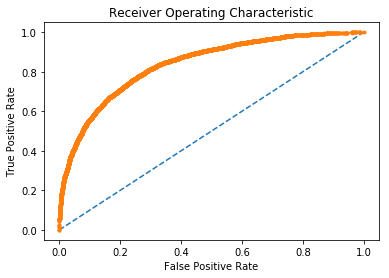

In [20]:
auc = roc_auc_score(y_val, check)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_val, check)
# plot no skill
pyplot.title('Receiver Operating Characteristic')
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr,marker='.')
pyplot.ylabel('True Positive Rate')
pyplot.xlabel('False Positive Rate')
# show the plot
pyplot.show() 

In [21]:
dictvar = bst.get_score(importance_type='gain')
impft = pd.DataFrame(columns=['feature','importance'])

In [22]:
for column in TrainDF:
    impft = impft.append({'feature' : column , 'importance' : dictvar.get(column)} , ignore_index=True)

In [23]:
impft.sort_values('importance',ascending=False)

,feature,importance
141,var_139,82.948537
80,var_78,82.235556
112,var_110,76.701811
83,var_81,76.460324
172,var_170,73.634452
55,var_53,73.593699
2,var_0,72.194200
148,var_146,69.945226
199,var_197,66.082306
101,var_99,64.795127


As shown above we can see featurewise importance ****

We can plot a tree with below code****

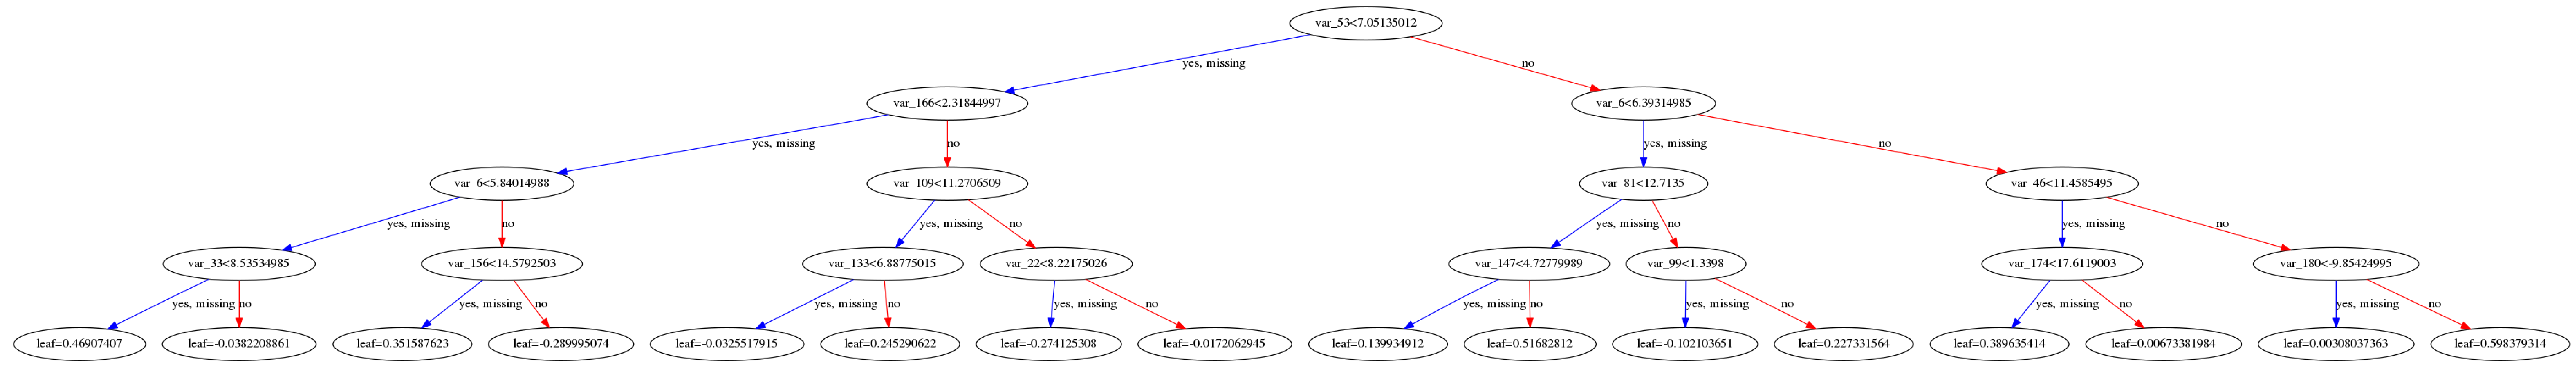

In [24]:
xgb.plot_tree(bst, num_trees=1)
fig = pyplot.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

In [ ]:
fig, ax = pyplot.subplots(figsize=(200, 500))
xgb.plot_importance(bst, ax=ax)

We are finally predicting on our Test data now****

In [25]:
TestDF['target'] = bst.predict(xgb.DMatrix(TestDF.drop(['ID_code'],axis=1)), ntree_limit=bst.best_iteration+1)

In [27]:
Solution = TestDF[['ID_code','target']]
Solution.to_csv("Santander_CustomerTransaction.csv", index=False)